In [1]:
import sys 
sys.path.append('/data3/KJE/code/WIL_DeepLearningProject_2/VLM_Hallu')
import argparse
import os
import random
from typing import List, Union, Optional, Dict, Tuple
import gc

import numpy as np
import pandas as pd

import torch
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

import wandb

from transformers import AutoProcessor, LlavaForConditionalGeneration, set_seed  # noqa: F401
import src.probing_utils as utils

ModuleNotFoundError: No module named 'src.probing_utils'

In [ ]:
df = pd.read_csv('/data3/KJE/code/WIL_DeepLearningProject_2/VLM_Hallu/data/preprocess/llava-1.5-7b-hf-vizwiz_val-llava_answers_label_change.csv')
required_cols = {"image_path", "question", "label"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required column(s) in CSV: {missing}")

train_df = pd.read_csv('/data3/KJE/code/WIL_DeepLearningProject_2/VLM_Hallu/data/preprocess/llava-1.5-7b-hf-vizwiz_train-llava_answers_label_change.csv')


train_idx = list(range(len(train_df)))
valid_idx = list(range(len(df)))

In [101]:
tokens_to_probe: List[Union[str, int]] = [
       "last_question_text_token",
       "step_3","step_2","step_1",
        -3, -2, -1
    ]

In [102]:
def parse_subset_layers(arg_val: Optional[str], num_layers: int) -> List[int]:
    if not arg_val:
        return list(range(num_layers))
    raw = [s.strip() for s in arg_val.split(",") if s.strip() != ""]
    idxs: List[int] = []
    for s in raw:
        i = int(s)
        if i < 0:
            i = num_layers + i  # negative index from end
        if not (0 <= i < num_layers):
            raise ValueError(f"subset_layers index out of range after normalization: {i} (num_layers={num_layers})")
        idxs.append(i)
    # keep order but uniquify
    seen = set()
    ordered = []
    for i in idxs:
        if i not in seen:
            ordered.append(i)
            seen.add(i)
    return ordered

In [103]:
model, processor, tokenizer = utils.load_llava('llava-hf/llava-1.5-7b-hf')
num_layers = utils.get_num_layers_from_config(model)
subset_layers = parse_subset_layers(None, num_layers)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [105]:
probes: Dict[Tuple[str, int], SGDClassifier] = {}
initialized: Dict[Tuple[str, int], bool] = {}

In [154]:
def get_num_layers_from_config(model) -> int:
    cfg = getattr(model, "config", None)
    if hasattr(cfg, "text_config") and hasattr(cfg.text_config, "num_hidden_layers"):
        return int(cfg.text_config.num_hidden_layers)
    if hasattr(cfg, "num_hidden_layers"):
        return int(cfg.num_hidden_layers)
    raise ValueError("Cannot find num_hidden_layers in config.")

def get_image_token_id(model) -> Optional[int]:
    return getattr(getattr(model, "config", None), "image_token_index", None)

def tokkey(t):
    return str(t) if isinstance(t, int) else t

In [144]:
#collect_features_for_split 
device = next(model.parameters()).device
dtype = next(model.parameters()).dtype
num_layers = get_num_layers_from_config(model)
image_token_id = get_image_token_id(model)

neg_ks = sorted([k for k in tokens_to_probe if isinstance(k, int)])

token_keys = [tokkey(t) for t in tokens_to_probe]
features: Dict[str, Dict[int, List[np.ndarray]]] = {k: {l: [] for l in range(num_layers)} for k in token_keys}
labels: Dict[str, List[int]] = {k: [] for k in token_keys}

In [146]:
neg_ks, token_keys ,features.keys(),labels

([-3, -2, -1],
 ['last_question_text_token', 'step_3', 'step_2', 'step_1', '-3', '-2', '-1'],
 dict_keys(['last_question_text_token', 'step_3', 'step_2', 'step_1', '-3', '-2', '-1']),
 {'last_question_text_token': [],
  'step_3': [],
  'step_2': [],
  'step_1': [],
  '-3': [],
  '-2': [],
  '-1': []})

In [114]:
image_root = '/data3/KJE/code/WIL_DeepLearningProject_2/VLM_Hallu/data/COCO/images/val2014'
def _img_path(p):
    if image_root is None:
        return p
    return os.path.join(image_root, p)

In [115]:
def build_prompt(tokenizer, question: str) -> str:
    # 메시지 안에 이미지 + 텍스트 구성
    content = [{"type": "image"}, {"type": "text", "text": question+'Answer in one word.'}]
    if hasattr(tokenizer, "apply_chat_template"):
        messages = [{"role": "user", "content": content}]
        try:
            prompt = tokenizer.apply_chat_template(
                messages,
                add_generation_prompt=True,
                tokenize=False
            )
            return prompt
        except Exception:
            pass
    # fallback: 단순 프롬프트
    return "<image>\n" + question.strip() + "\n"

In [87]:
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

batch_size = 1

# load images & prompts
images = []
prompts = []
ys = []

for start in tqdm(range(0, 3, batch_size)):
        batch_idx = train_idx[start : start + batch_size]
        rows = df.iloc[batch_idx]

        for _, r in rows.iterrows():
            img = Image.open(_img_path(r["image_path"])).convert("RGB")
            images.append(img)
            prompts.append(build_prompt(tokenizer, str(r["question"]))
                           if "question" in r else build_prompt(tokenizer, str(r["text"])))
            ys.append(int(r["label"]))
        # encode
        batch = processor(
            images=images,
            text=prompts,
            padding=True,
            return_tensors="pt"
        )
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(dtype=dtype, device=device)

        out = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            output_hidden_states=True,
            return_dict_in_generate=True,
            use_cache=False
        )


100%|██████████| 3/3 [00:01<00:00,  1.65it/s]


USER: <image>
Can you tell me what this medicine is please?Answer in one word. ASSISTANT:
<s> USER: <image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><ima

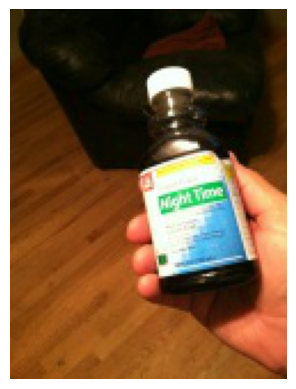

USER: <image>
What is the title of this book? Answer in one word. ASSISTANT:
<pad><pad><s> USER: <image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image>

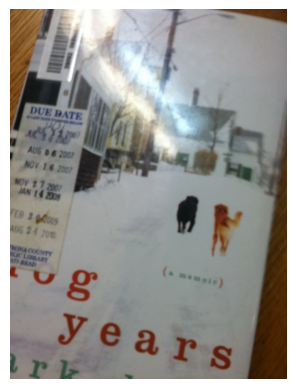

USER: <image>
Which one is the blue one?Answer in one word. ASSISTANT:
<pad><pad><s> USER: <image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image><image

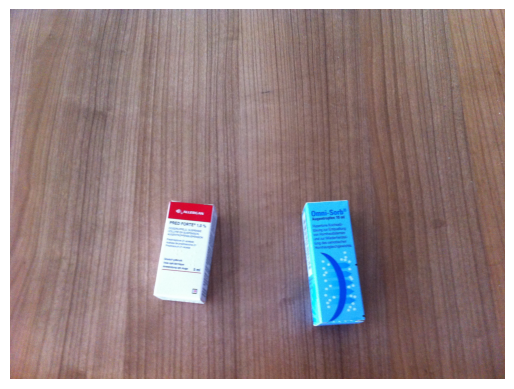

In [88]:
for i in range(len(images)):
    plt.imshow(images[i])
    print(prompts[i])
    print(processor.decode(out[0][i]))
    plt.axis("off")  # 축 눈금 제거
    plt.show()


In [89]:
for i in range(0,3):
    # for layer in range(0,33):
    print(out.hidden_states[i][0].shape) #0~32 layer 수 

torch.Size([3, 603, 4096])
torch.Size([3, 604, 4096])
torch.Size([3, 605, 4096])


In [90]:
hs = torch.stack(out.hidden_states[-1][1:], dim=0)  # [L, B, T, H]

In [149]:
def nonpad_indices(attn_mask: torch.Tensor) -> torch.Tensor:
    # returns positions where attention_mask == 1
    return torch.nonzero(attn_mask, as_tuple=False).squeeze(-1)

def locate_positions_for_sample(
    input_ids: torch.Tensor,
    attention_mask: torch.Tensor,
    image_token_id: Optional[int],
    neg_ks: List[int],
) -> Dict[str, Optional[int]]:
    
    pos = {}
    idxs = nonpad_indices(attention_mask)
    if idxs.numel() == 0:
        # all pad? shouldn't happen
        for k in neg_ks:
            pos[str(k)] = None
        pos["last_question_text_token"] = None
        return pos

    # last/first non-pad
    first_idx = int(idxs[0].item())
    last_idx = int(idxs[-1].item())

    # negative offsets from end
    for k in neg_ks:  # e.g., -8..-1
        kk = abs(k)
        if kk <= idxs.numel():
            pos[str(k)] = int(idxs[-kk].item())
        else:
            pos[str(k)] = None


    pos["last_question_text_token"] = last_idx

    return pos


In [150]:
per_step_lastlayer_lasttoken = torch.stack(
    [layer_hs_tuple[-1][:, -1, :]        
     for layer_hs_tuple in out.hidden_states],
    dim=0                                   # (steps, batch, hidden)
)

per_step_alllayers_lasttoken = torch.stack(
    [torch.stack([h[:, -1, :]            
                  for h in layer_hs_tuple[1:]],  
                 dim=0)                    # (layers, batch, hidden)
     for layer_hs_tuple in out.hidden_states],
    dim=0                                   # (steps, layers, batch, hidden)
).permute(0, 2, 1, 3)                        # (steps, batch, layers, hidden)

print(per_step_lastlayer_lasttoken.shape)     # torch.Size([steps, batch, hidden])
print(per_step_alllayers_lasttoken.shape)     # torch.Size([steps, batch, layers, hidden])

torch.Size([3, 3, 4096])
torch.Size([3, 3, 32, 4096])


In [155]:
tokens_to_probe

['last_question_text_token', 'step_3', 'step_2', 'step_1', -3, -2, -1]

In [160]:
tokkey('step_3') 

'step_3'

In [186]:
B = input_ids.size(0)
for b in range(B):
    yb = ys[b]
    # import pdb;pdb.set_trace()
    pos_map = locate_positions_for_sample(
        input_ids[b], attention_mask[b],  image_token_id, neg_ks
    ) 
    # build a per-token valid mask & per-token position
    for t in tokens_to_probe:
        k = tokkey(t)                 
        p = pos_map.get(k, None)         
        # if p is None:
        #     continue  # skip this sample for this token
        # append label once per sample (per token)
        labels[k].append(yb)

        # for each layer, slice feature
        for l in range(num_layers):
            vec = hs[l, b, p, :].detach().float().cpu().numpy()  # (H,)
            features[k][l].append(vec)

        if "step" in k:
            step_num = int(k.split("_")[-1])   # e.g. "step_3" -> 3
            step_idx = step_num - 1            # 0-based index

            # 각 layer별 slice
            for l in range(num_layers):
                vec = (
                    per_step_alllayers_lasttoken[step_idx, b, l, :]  # (H,)
                    .detach()
                    .float()
                    .cpu()
                    .numpy()
                )
                features[k][l].append(vec)

In [187]:
def safe_stack(feat_list: List[np.ndarray], dtype=np.float32) -> Optional[np.ndarray]:
    """Preallocate and copy row-by-row to avoid transient double-allocation."""
    if not feat_list:
        return None
    first = np.asarray(feat_list[0])
    out = np.empty((len(feat_list),) + first.shape, dtype=dtype)
    for i, a in enumerate(feat_list):
        ai = np.asarray(a)
        if ai.shape != first.shape:
            raise ValueError(f"Inconsistent feature shape at {i}: {ai.shape} vs {first.shape}")
        out[i] = ai.astype(dtype, copy=False)
    return out

In [192]:
features.keys()

dict_keys(['last_question_text_token', 'step_3', 'step_2', 'step_1', '-3', '-2', '-1'])

In [ ]:
len(features['last_question_text_token'][0])

33

: 

In [188]:
for tok in tokens_to_probe:
    key = tokkey(tok)
    y_list = labels.get(key, [])
    # import pdb;pdb.set_trace()
    # if len(y_list) == 0:
    #     continue
    y_arr = np.asarray(y_list, dtype=np.int32)

    for l in subset_layers:
        X_list = features.get(key, {}).get(l, [])
        if len(X_list) == 0:
            continue
        X_arr = safe_stack(X_list, dtype=np.float32)
        k = (key, l)
        if k not in probes:
            probes[k] = SGDClassifier(loss="log_loss", alpha=1e-4, learning_rate="constant", eta0=1e-2, max_iter=1, warm_start=True)
            initialized[k] = False
        
        if not initialized[k]:
            probes[k].partial_fit(X_arr, y_arr, classes=np.array([0, 1], dtype=np.int32))
            initialized[k] = True
        else:
            probes[k].partial_fit(X_arr, y_arr)

        
        del X_arr, X_list
    del y_arr, y_list

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

y_true_map: Dict[Tuple[str, int], List[int]] = {}
y_score_map: Dict[Tuple[str, int], List[float]] = {}


ValueError: Inconsistent feature shape at 18: (1, 603, 4096) vs (4096,)